# Challenge: Preparing a dataset for modeling

Unit 2: Lesson 1: 7

## Divorce in South Africa

Data: [StatsSA](https://www.datafirst.uct.ac.za/dataportal/index.php/catalog/568/get_microdata)


Using a dataset of your choice, select an outcome variable and then pick four or five other variables (one to two categorical, three to four continuous) to act as the basis for features. Explore the variables using the univariate and bivariate methods you've learned so far.

Next, based on what you learned via your data exploration, create ten new features. Explain the reasoning behind each one.

Finally, use filtering methods to select the five best features and justify your choices.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [6]:
divorce = pd.read_csv('md-2014-divorces-v1-20160503.csv')
divorce.head()

,MaleRace,FemaleRace,CoupleRace,MaleOccupation,FemaleOccupation,PlaintiffSex,PlaintiffOccupation,MaleStatus,FemaleStatus,MaleNoTimesMarried,...,MarriagePropertySystem,MarriageMonth,MarriageYear,NoOfChildren,DivorceYear,DivorceMonth,DurationOfMarriage,MarriageType,PolygamousMarriage,GroundsForDivorce
0,4,4,4,99,99,1,99,3,3,2,...,1,3,2014,0,2014,8,0,9,9,9
1,4,4,4,1,2,2,2,3,3,2,...,1,1,2014,0,2014,7,0,9,9,9
2,1,1,1,99,99,9,99,9,9,99,...,1,5,2014,2,2014,8,0,9,9,9
3,3,3,3,1,1,1,1,3,3,2,...,2,1,2014,0,2014,3,0,9,9,9
4,2,2,2,0,3,2,3,1,9,1,...,1,8,2014,3,2014,1,0,9,9,9


In [18]:
print(divorce.shape)
columnlist=divorce.columns
print(columnlist)

(24689, 24)
Index(['MaleRace', 'FemaleRace', 'CoupleRace', 'MaleOccupation',
       'FemaleOccupation', 'PlaintiffSex', 'PlaintiffOccupation', 'MaleStatus',
       'FemaleStatus', 'MaleNoTimesMarried', 'FemaleNoTimesMarried', 'MaleAge',
       'FemaleAge', 'SolemnisationCode', 'MarriagePropertySystem',
       'MarriageMonth', 'MarriageYear', 'NoOfChildren', 'DivorceYear',
       'DivorceMonth', 'DurationOfMarriage', 'MarriageType',
       'PolygamousMarriage', 'GroundsForDivorce'],
      dtype='object')


The dependent variable selected for this dataset is the length of the marraige (DurationofMarraige). Note that since the dataset *only* contains divorces of 2014, it is only a partial dataset. One solution is to run a Heckman two-step type approach to account for the fact that the sample only includes divorces (the first step is a logit/probit to account for the selection followed by the regression model on the continuous variable). 

The independent variables used will include:
- Age
- Occupation
- Sex of the plaintiff
- Occupation of plaintiff
- Number of times married
- Marriage property system
- Type of marriage
- Number of children


In [41]:
#Removing outliers from DurationOfMarriage, from data description missing coded as 999
divorce = divorce[divorce['DurationOfMarriage']!=999]

#Reset missing data as NaN for the rest of the variables (coded as 9 or 99 or 999)
divorce['MaleOccupation'].replace(99, np.NaN, inplace=True)
divorce['FemaleOccupation'].replace(99, np.NaN, inplace=True)
divorce['PlaintiffSex'].replace(9,np.NaN, inplace=True)
divorce['PlaintiffOccupation'].replace(99,np.NaN, inplace=True)
divorce['MaleStatus'].replace(9,np.NaN, inplace=True)
divorce['FemaleStatus'].replace(9,np.NaN, inplace=True)
divorce['MaleNoTimesMarried'].replace(99,np.NaN, inplace=True)
divorce['FemaleNoTimesMarried'].replace(99,np.NaN, inplace=True)
divorce['MaleAge'].replace(999, np.NaN, inplace=True)
divorce['FemaleAge'].replace(999, np.NaN, inplace=True)
divorce['SolemnisationCode'].replace(9, np.NaN, inplace=True)
divorce['MarriagePropertySystem'].replace(9, np.NaN, inplace=True)
divorce['MarriageYear'].replace(9999, np.NaN, inplace=True)
divorce['MarriageType'].replace(9, np.NaN, inplace=True)

# Variables for polygamy and grounds for divorce are more than 90% unspecified and therefore cannot be used


In [78]:
# A lot of unspecified data unfortunately
divorce.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23798 entries, 0 to 23797
Data columns (total 24 columns):
MaleRace                  23798 non-null int64
FemaleRace                23798 non-null int64
CoupleRace                23798 non-null int64
MaleOccupation            16265 non-null float64
FemaleOccupation          15487 non-null float64
PlaintiffSex              20589 non-null float64
PlaintiffOccupation       14509 non-null float64
MaleStatus                21832 non-null float64
FemaleStatus              21220 non-null float64
MaleNoTimesMarried        22954 non-null float64
FemaleNoTimesMarried      22820 non-null float64
MaleAge                   21925 non-null float64
FemaleAge                 22160 non-null float64
SolemnisationCode         21799 non-null float64
MarriagePropertySystem    23023 non-null float64
MarriageMonth             23798 non-null int64
MarriageYear              23798 non-null int64
NoOfChildren              23798 non-null int64
DivorceYear          

In [42]:
divorce.MaleOccupation.describe()

count    16265.000000
mean         2.738088
std          2.510213
min          0.000000
25%          1.000000
50%          2.000000
75%          5.000000
max          8.000000
Name: MaleOccupation, dtype: float64

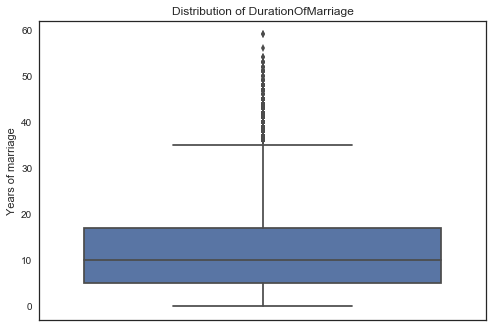

In [45]:
sns.set(style='white')

# Checking new distribution
sns.boxplot(y=divorce.DurationOfMarriage)
plt.ylabel('Years of marriage')
plt.title('Distribution of DurationOfMarriage')
plt.show()

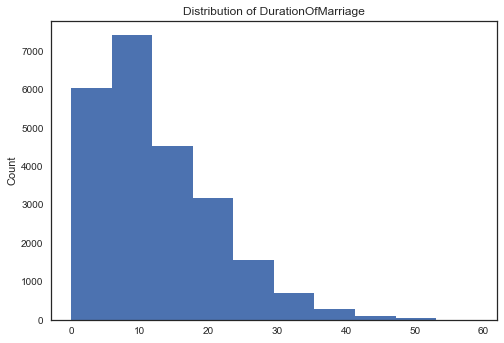

In [44]:
plt.hist(divorce.DurationOfMarriage)
plt.title('Distribution of DurationOfMarriage')
plt.ylabel('Count')
plt.show()

Distribution of marriage duration is strongly skewed to the right. It seems marriages have a higher probability of failing in the first 10 years, but then this drops off substantially. Since I'm not using this variable in any models there is no need to transform it into a normal distribution.

In [51]:
divorce_small = divorce.loc[:, ['DurationOfMarriage', 'MaleAge', 'FemaleAge', 'NoOfChildren']]
divorce_small.head()

,DurationOfMarriage,MaleAge,FemaleAge,NoOfChildren
0,0,48.0,48.0,0
1,0,43.0,33.0,0
2,0,49.0,37.0,2
3,0,48.0,47.0,0
4,0,35.0,32.0,3


C:\Users\User\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


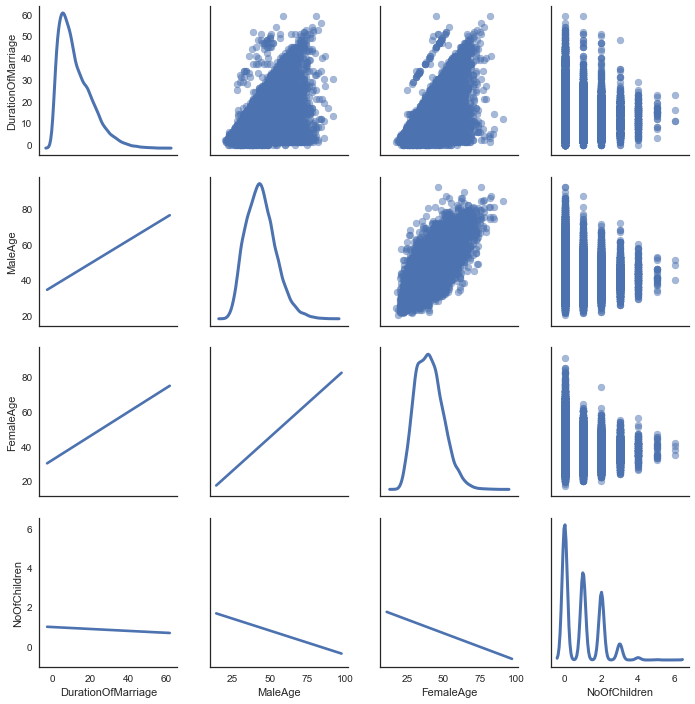

In [52]:
g =sns.PairGrid(divorce_small, diag_sharey=False)
g.map_upper(plt.scatter, alpha=.5)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.kdeplot, lw=3)
plt.show()

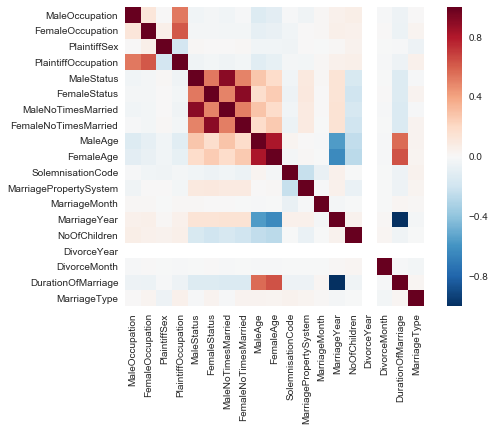

In [91]:
#Remove some unused columns
divorces = divorce.loc[:, 'MaleOccupation':'MarriageType']

#Correlation matrix
corrs = divorces.corr()
plt.plot(figsize=(12,8))
sns.heatmap(corrs, square=True)
plt.show()

A somewhat disappointing correlation matrix. Duration of marriage is strongly (positively) correlated with the age of both parties. Some negative correlation with number of times married and status. But also a lot of weak (or no) correlations).

Several variables are highly correlated by design and should not be included into a model at the same time, e.g. status (bachelor, divorce, widower) and number of times married.

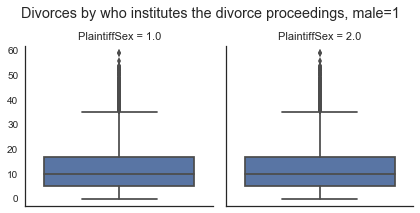

In [74]:
# Data is already in long form since there are no index-able variables?

f = sns.FacetGrid(divorces, col='PlaintiffSex')
f.map(sns.boxplot, y=divorces["DurationOfMarriage"])
plt.suptitle('Divorces by who institutes the divorce proceedings, male=1')
plt.subplots_adjust(top=0.8)
plt.show()

No differences here. Moving along folks...

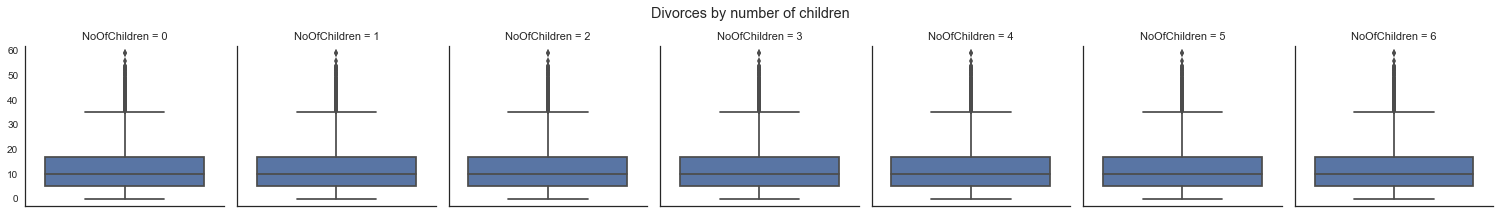

In [77]:
f = sns.FacetGrid(divorces, col='NoOfChildren')
f.map(sns.boxplot, y=divorces["DurationOfMarriage"])
plt.suptitle('Divorces by number of children')
plt.subplots_adjust(top=0.8)
plt.show()

Maybe the kids didn't cause the divorce afterall. But really, 6 is a bit much...

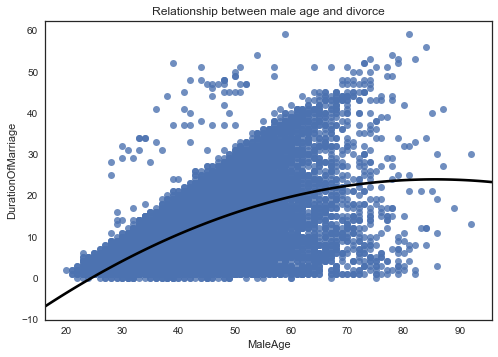

In [61]:
sns.regplot('MaleAge', 'DurationOfMarriage', order=2, scatter=True, data=divorces, ci=None, line_kws={'color':'black'})
plt.title('Relationship between male age and divorce')
plt.show()

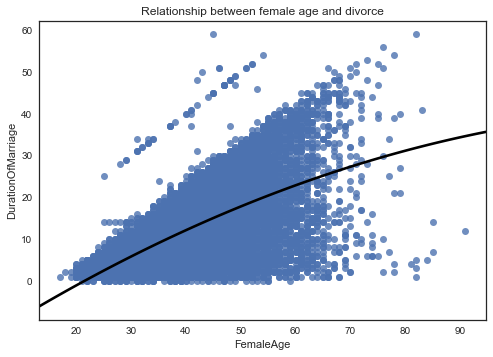

In [62]:
sns.regplot('FemaleAge', 'DurationOfMarriage', order=2, scatter=True, data=divorces, ci=None, line_kws={'color':'black'})
plt.title('Relationship between female age and divorce')
plt.show()

So not as strong a quadratic relationship as what might have been expected.

In [106]:
# Creating some new features

# Dummies for occupation, these are categorical so it's no use on their own 
occupyM = pd.get_dummies(divorces['MaleOccupation'])
occupyM.rename(columns={0.0:'OccM_Nothing', 1.0:'OccM_Prof', 2.0:'OccM_Manager',
                        3.0:'OccM_Cleric', 4.0:'OccM_Trans', 5.0:'OccM_Service',
                        6.0:'OccM_Farm', 7.0:'OccM_Artisan', 8.0:'OccM_Mine'})

occupyF = pd.get_dummies(divorces['FemaleOccupation'])
occupyF.rename(columns={0.0:'OccF_Nothing', 1.0:'OccF_Prof', 2.0:'OccF_Manager',
                        3.0:'OccF_Cleric', 4.0:'OccF_Trans', 5.0:'OccF_Service',
                        6.0:'OccF_Farm', 7.0:'OccF_Artisan', 8.0:'OccF_Mine'})

# Age and kids - normalize age? In regression generally just go straight for interaction?
divorces['AgeM_kids_comb'] = divorces['MaleAge']*divorces['NoOfChildren']
divorces['AgeF_kids_comb'] = divorces['FemaleAge']*divorces['NoOfChildren']

# Difference in ages of partners or the "what do you mean you never watched MacGuyver" variable
divorces['Age_gap'] = divorces['MaleAge']-divorces['FemaleAge']

# Does the contract theory of marriage apply? Creating dummies for type of marriage property
propertySplit = pd.get_dummies(divorces['MarriagePropertySystem'])
propertySplit.rename(columns={1.0:"InCommunity", 2.0:"OutCommunity", 3.0:'OutCommunity_noAccr',
                              4.0:'OutCommunity_wAccr', 5.0:'Other'})

,InCommunity,OutCommunity,OutCommunity_noAccr,OutCommunity_wAccr,Other
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,0,1,0,0,0
4,1,0,0,0,0
5,1,0,0,0,0
6,0,0,0,1,0
7,0,1,0,0,0
8,1,0,0,0,0
9,0,0,0,1,0


In [95]:
print(occupyM.shape)
print(occupyF.shape)
print(propertySplit.shape)
print(divorces.shape)

(23798, 9)
(23798, 9)
(23798, 5)
(23798, 22)


In [107]:
# Add DurationOfMarriage into occupy and propertySplit (easier to view than other way around)
occupyM['DurationOfMarriage']=divorces['DurationOfMarriage']
occupyF['DurationOfMarriage']=divorces['DurationOfMarriage']
propertySplit['DurationOfMarriage']=divorces['DurationOfMarriage']


In [108]:
# Using filter method to only whittle away some variables.

# Using (absolute) correlation to pick filter
# This has some problematic assumptions - including ignoring interaction - that will be ignored for now
corrsM = occupyM.corr()
corrsF = occupyF.corr()
corr_property = propertySplit.corr()

In [109]:
corrs.loc['DurationOfMarriage',:]

MaleOccupation           -0.053141
FemaleOccupation         -0.058432
PlaintiffSex             -0.015199
PlaintiffOccupation      -0.050311
MaleStatus               -0.135461
FemaleStatus             -0.135847
MaleNoTimesMarried       -0.146132
FemaleNoTimesMarried     -0.141432
MaleAge                   0.566295
FemaleAge                 0.632955
SolemnisationCode        -0.052777
MarriagePropertySystem   -0.047730
MarriageMonth             0.023368
MarriageYear             -1.000000
NoOfChildren             -0.043551
DivorceYear                    NaN
DivorceMonth             -0.013391
DurationOfMarriage        1.000000
MarriageType              0.023188
Name: DurationOfMarriage, dtype: float64

In [111]:
corrsM.loc['DurationOfMarriage',:]

0.0                   0.060630
1.0                  -0.020156
2.0                   0.017807
3.0                  -0.056741
4.0                   0.008048
5.0                  -0.022296
6.0                   0.025418
7.0                  -0.026920
8.0                  -0.003450
DurationOfMarriage    1.000000
Name: DurationOfMarriage, dtype: float64

In [112]:
corrsF.loc['DurationOfMarriage',:]

0.0                   0.062266
1.0                  -0.012267
2.0                  -0.007342
3.0                  -0.055911
4.0                  -0.000396
5.0                  -0.009822
6.0                   0.001980
7.0                  -0.004053
8.0                   0.000834
DurationOfMarriage    1.000000
Name: DurationOfMarriage, dtype: float64

In [113]:
corr_property.loc['DurationOfMarriage',:]

1.0                   0.028257
2.0                   0.033108
3.0                  -0.050513
4.0                  -0.039828
5.0                   0.010002
DurationOfMarriage    1.000000
Name: DurationOfMarriage, dtype: float64

So despite all the variables, the best ones to use are still male and female age, and number of times the person was married.